In [1]:
import pandas as pd
import numpy as np
import warnings

In [2]:
warnings.filterwarnings(action='ignore')

In [3]:
df = pd.read_hdf('../data//tokenized_10thousand.hdf')

In [4]:
# json으로 저장한 단어 사전 불러오기
import json

with open('./id_dict/input_id.json', 'r') as fp:
    input_id = json.load(fp)

with open('./id_dict/target_id.json', 'r') as fp:
    target_id = json.load(fp)


In [5]:
# 데이터셋을 아이디값으로 변환(vectorize)
original = df.original.apply(lambda y :np.array(list(map(lambda x:input_id[x], y)))).to_numpy()
# 한글의 경우 20000개 안에 없는 단어가 있을 수 있다.
# OOV 아이디인 1로 바꿔줘야 한다.
translation = df.translation.apply(lambda y :np.array(list(map(lambda x:target_id.setdefault(x, 1), y)))).to_numpy()

In [6]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [7]:
encoder_input_data = pad_sequences(original, maxlen=200, padding='post', truncating='post')
decoder_target_data = pad_sequences(translation, maxlen=200, padding='post', truncating='post')

In [8]:
encoder_input_data

array([[ 11, 516, 202, ..., 713, 604, 426],
       [ 11,  14, 117, ..., 178,  24,   3],
       [ 11, 345, 613, ...,   0,   0,   0],
       ...,
       [ 11, 391,  44, ...,   0,   0,   0],
       [ 11, 510,  43, ...,   0,   0,   0],
       [ 11, 413, 590, ...,   0,   0,   0]])

In [9]:
# decoder input data는 <start> character (== 2)로 시작해야 하며 1 time 씩 밀어내야 한다.
tmp = []
for t in translation:
    a = [2]
    a.extend(list(t))
    tmp.append(a)
tmp = np.array(tmp)

decoder_input_data = pad_sequences(tmp, maxlen=200, padding='post', truncating='post')

In [10]:
decoder_input_data

array([[   2,  913,   22, ...,   88,   26,   58],
       [   2,   65,    7, ...,   15,    5, 1647],
       [   2,  421,   22, ...,    0,    0,    0],
       ...,
       [   2,  717,    1, ...,    0,    0,    0],
       [   2, 2362,  416, ...,    0,    0,    0],
       [   2,  139,    4, ...,    0,    0,    0]])

In [11]:
encoder_input_data.shape, decoder_target_data.shape, decoder_input_data.shape

((99996, 200), (99996, 200), (99996, 200))

In [12]:
batch_size = 1  # Batch size for training.
epochs = 1  # Number of epochs to train for.
latent_dim = 256  # 인코더 차원
num_encoder_tokens = 7049 # unique한 한자 캐릭터의 수
num_decoder_tokens = 10003 # unique한 한글 토큰의 수
embedding_dim = 256 # 워드 임베딩 길이

In [13]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Softmax
from tensorflow.keras.models import Model

In [14]:
# Define an input sequence and process it.
encoder_input = Input(shape=(None,))
encoder_embedding = Embedding(num_encoder_tokens, embedding_dim)(encoder_input)
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embedding)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_input = Input(shape=(None,))
decoder_embedding = Embedding(num_decoder_tokens, embedding_dim)(decoder_input)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_input, decoder_input], decoder_outputs)

# Run training
# model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])
# model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
#           batch_size=batch_size,
#           epochs=epochs,
#           validation_split=0.2)
# # Save model
# model.save('s2s.h5')

In [15]:
from tensorflow.keras.models import load_model

In [16]:
model = load_model('./s2s.h5')

In [18]:
from tensorflow.keras.utils import plot_model

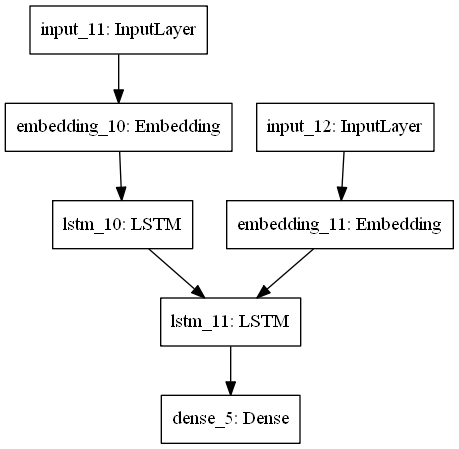

In [19]:
plot_model(model, './plot_model.png')

In [25]:
model.layers

In [29]:
encoder_inputs = model.input[0]   # input_1
encoder_embedding = model.layers[2](encoder_inputs)
encoder_outputs, state_h_enc, state_c_enc = model.layers[4].output   # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]   # input_2
decoder_embedding = model.layers[3](decoder_inputs)
decoder_state_input_h = Input(shape=(latent_dim,), name='input_3')
decoder_state_input_c = Input(shape=(latent_dim,), name='input_4')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[5]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_embedding, initial_state=decoder_states_inputs)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[6]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [31]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_id = dict(
    (i, char) for char, i in input_id.items())
reverse_target_id = dict(
    (i, char) for char, i in target_id.items())

In [33]:
reverse_target_id

{3: ',/SP',
 4: '하/XSV',
 5: './SF',
 6: '을/JKO',
 7: '이/JKS',
 8: '를/JKO',
 9: '에/JKB',
 10: '고/EC',
 11: '의/JKG',
 12: '"/SS',
 13: '았/EP',
 14: '아/EC',
 15: '다/EF',
 16: 'ㄴ/ETM',
 17: '하/VV',
 18: '것/NNB',
 19: '이/VCP',
 20: '는/ETM',
 21: '기/ETN',
 22: '가/JKS',
 23: '은/JX',
 24: '어/EC',
 25: '는/JX',
 26: '지/EC',
 27: '게/EC',
 28: 'ㄹ/ETM',
 29: '하/XSA',
 30: '·/SP',
 31: '었/EP',
 32: '말/NNG',
 33: '있/VV',
 34: 'ㅂ니다/EF',
 35: '없/VA',
 36: '에서/JKB',
 37: '그/MM',
 38: '으로/JKB',
 39: '니/EC',
 40: '않/VX',
 41: '로/JKB',
 42: '습니다/EF',
 43: '아서/EC',
 44: '도/JX',
 45: '는데/EC',
 46: '에게/JKB',
 47: '들/XSN',
 48: '으니/EC',
 49: '?/SF',
 50: '겠/EP',
 51: '과/JC',
 52: '등/NNB',
 53: '수/NNB',
 54: '사람/NNG',
 55: '아뢰/VV',
 56: '되/VV',
 57: '어서/EC',
 58: '못하/VX',
 59: '하/VX',
 60: '하니/NNP',
 61: '이/NP',
 62: '자/NNB',
 63: 'ㅁ/ETN',
 64: '은/ETM',
 65: '임금/NNG',
 66: '시/EP',
 67: '또/MAJ',
 68: '면/EC',
 69: '되/XSV',
 70: '을/ETM',
 71: '주/VX',
 72: '와/JC',
 73: '일/NNG',
 74: '모두/MAG',
 75: '이르/VV',
 76: '이

In [35]:
target_id['START']

2

In [67]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = 2

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)
        
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == 'PAD' or
           len(decoded_sentence) > 200):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
#     print('-')
#     print('Input sentence:', encoder_input_data[seq_index])
#     print('Decoded sentence:', decoded_sentence)
    with open('./result.txt', 'a') as fp:
        fp.write(decoded_sentence+'\n')

In [50]:
encoder_input_data[0:1]

array([[  11,  516,  202,   48,   42,  325,   46,  516,  202,    2,  209,
         219,  326,  241,   58,  423,  284,  226,    3,  237,   89,    2,
          89,  198,   42,   69,   46,  413,  612,    2,  693, 1046,  127,
         493,  209,  219,  464,    2,  214,  344,   96,    5,  142, 2257,
           2,  448, 1436,   90, 1072,    3,  238,   72, 1562,  321, 1198,
          18,  374,  103,   31,  616,   10,    7,    4,   30,  103, 1673,
        1759,    2,  102,   36,   90,  310,    2,   12,  182,   90,  318,
           2,    8,   22,   16,  748,  994,  129,  758,  206,    2,   47,
         646,    5,    3,    4,  534,  230,  616,  217,  646,  693, 1046,
           3,   15,  355,  183,    2,  280, 2187,  534,   96,  281,   53,
        1811,  375,  179, 1313,   19,  754,  217,    2,   79,  295, 1467,
        1222,   67,  508,  226,  476,  217,    2,  693, 1046,  960,  490,
         240,   52,   10,    7,    4, 2398,   94,    8,  121,   16,  102,
           2,  635,   27,  661, 2398, 